# POGM Example

## Setup

In [68]:
using Suppressor
using BM3D
using Images: assess_psnr, rmse, imROF
using TestImages
using MIRT: jim, pogm_restart
using PyCall
using Plots: plot, savefig
using Noise: add_gauss
using LaTeXStrings

np = pyimport("numpy")
cv = pyimport_conda("cv2", "opencv")
# Inclucde needed files
include("admm.jl")
include("load_fastmri_data.jl")
include("system_ops.jl")
include("create_sampling_mask.jl")
include("utils.jl")
include("primal.jl")
@suppress include("dncnn.jl") # Suppress weight printing

# Create a single Julia function for calling nlmeans
function nlMeans(img::Array{Float64, 2}, h::Number = 3) 
    pyimg = np.uint8(convert(Array{UInt8,2}, floor.(img/max(img...)*255))) # Convert julia image to np.uint8 array
    img_denoised = float32.(cv.fastNlMeansDenoising(pyimg, h=h)) ./ 255
end

function nlMeans(img::Array{Float32, 2}, h::Number = 3) 
    pyimg = np.uint8(convert(Array{UInt8,2}, floor.(img/max(img...)*255))) # Convert julia image to np.uint8 array
    img_denoised = float32.(cv.fastNlMeansDenoising(pyimg, h=h)) ./ 255
end
# Useful to flip images
function rev(img::AbstractArray{T, 2}) where T
    img[end:-1:1, end:-1:1]
end

normIm = (x) -> abs.(x) |> (x) -> x/max(x...); 

In [54]:
# Make a dictionary of the priors
plugs = Dict(
    "dncnn" => (x)          -> normIm( dncnn_denoise(float32.(abs.(x))) ),
    "tv"    => (x, λ, iter) -> normIm( imROF(abs.(x), λ, iter) ),
    "nlm"   => (x, h)       -> normIm( nlMeans(abs.(x), h) ),
    "norm"  => (x)          -> normIm(x),
    "bm3d"  => (x, h)       -> normIm( bm3d(abs.(x), h) )
    );

# Create an undersampled data set

In [11]:
useFastMRI = true
if useFastMRI 
    # Load a fully sampled image
    fName = "file1000000.h5" # File name
    # fPath = joinpath(pwd(), "data", fName) # Full file path
    fPath = joinpath(dirname(pwd()), "data", fName) # Full file path
    img = abs.(load_fastmri_data(fPath))
    # Use a denoised image b/c PnP denoises
    img = nlMeans(img, 3)
    img = img / max(img...)
else
    # Make orientation consistent with fastMRI
    img = rev(shepp_logan(256)')
end
(M,N) = size(img);
# Make a noisy image too
noisy_img = add_gauss(img, 0.05);

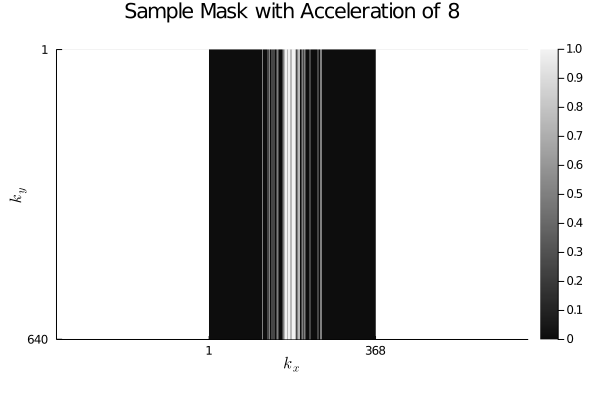

In [12]:
# Specify acceleration factor for sampling mask
R = 8
if R == 1
    sampleMask = ones(Bool, M, N)
    M_us = M
else
    M_us = Int(round(M/R)) # Undersampled number of points
    # Create a 1D random undersampling mask
    sampleMask = create_sampling_mask(M, N, R, seed=0)
end

jim(sampleMask, title="Sample Mask with Acceleration of " * string(R), xlabel=L"k_x", ylabel=L"k_y")

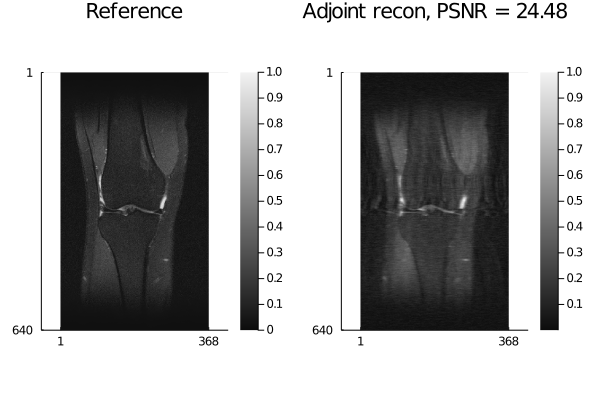

In [13]:
# Create linear map, A, that describes the MRI system model
A = LinearMapAA(x -> sys_forw(x, sampleMask), x -> sys_adj(x,sampleMask), (M_us*N, M*N))
# Apply model to image -> generate an undersampled k-space
y = A*noisy_img[:]
# Applying adjoint model to k-space reconstructs the image (poorly)
x0 = abs.(reshape(A'*y,M,N)) |> (x) -> x/max(x...)
# Make some plots
psnrAdjoint = assess_psnr(x0, img) # PSNR
j1 = jim(abs.(rev(img)),title="Reference")
j2 = jim(rev(x0),title="Adjoint recon, PSNR = $(round(psnrAdjoint, digits = 2))")
plot(j1, j2)

## Plug and Play!

In [15]:
nIter = 10

10

### Using DNCNN

In [65]:
# Setup the plug
plug = (x)-> plugs["dncnn"](x)
# Reconstruct
x̂DNCNN, nrmse_pogm = pogm_restart(
    x0[:],
    (x) -> undef,
    (x) -> A'*(A*x-y),
    2,
    g_prox = (x,c) -> plug(reshape(x, M, N))[:],
    restart = :none, 
    niter = nIter,
    fun = (aa,x,ac,ad) -> rmse(x, img[:])
    )

# Reshape and normalize
x̂DNCNN = normIm( reshape(abs.(x̂DNCNN), M, N) );

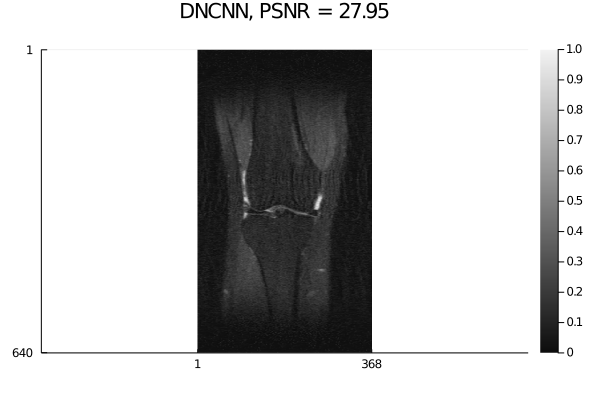

In [66]:
psnrDNCNN = assess_psnr(x̂DNCNN, img) # PSNR
pDNCNN = jim(abs.(rev(x̂DNCNN)), title="DNCNN, PSNR = $(round(psnrDNCNN, digits = 2))")

### Using TV

In [46]:
# Setup the plug
λ = 0.002
tvIter = 4
plug = (x) -> plugs["tv"](x, λ, tvIter)
# Reconstruct
x̂Tv, nrmse_pogm = pogm_restart(
    x0[:],
    (x) -> undef,
    (x) -> A'*(A*x-y),
    2,
    g_prox = (x, c) -> plug(reshape(x, M, N))[:],
    restart = :none, 
    niter = nIter,
    fun = (aa,x,ac,ad) -> rmse(x, img[:])
    )

# Reshape and normalize
x̂Tv = normIm( reshape(abs.(x̂Tv), M, N) );

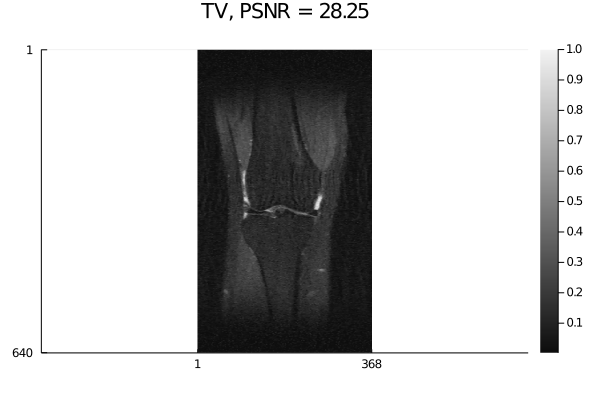

In [47]:
psnrTv = assess_psnr(x̂Tv, img) # PSNR
pTv = jim(abs.(rev(x̂Tv)), title="TV, PSNR = $(round(psnrTv, digits = 2))")

### Using NLMeans

In [48]:
# Setup the plug
h = 3.0
plug = (x) -> plugs["nlm"](x, h)
# Reconstruct
x̂NLMeans, nrmse_pogm = pogm_restart(
    x0[:],
    (x) -> undef,
    (x) -> A'*(A*x-y),
    2,
    g_prox = (x, c) -> plug(reshape(x, M, N))[:],
    restart = :none, 
    niter = nIter,
    fun = (aa,x,ac,ad) -> rmse(x, img[:])
    )

# Reshape and normalize
x̂NLMeans = normIm( reshape(abs.(x̂NLMeans),M,N) );

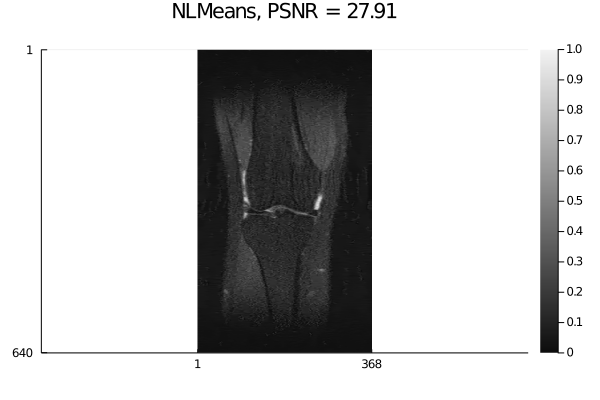

In [49]:
psnrNLMeans = assess_psnr(x̂NLMeans, img) # PSNR
pNLMeans = jim(abs.(rev(x̂NLMeans)), title="NLMeans, PSNR = $(round(psnrNLMeans, digits = 2))")

### Using BM3D

In [50]:
# Setup plug
h    = 0.08
plug = (x) -> @suppress plugs["bm3d"](x, h)
# Reconstruct
x̂BM3D, nrmse_pogm = pogm_restart(
    x0[:],
    (x) -> undef,
    (x) -> A'*(A*x-y),
    2,
    g_prox = (x, c) -> plug(reshape(x, M, N))[:],
    restart = :none, 
    niter = nIter,
    fun = (aa,x,ac,ad) -> rmse(x, img[:])
    )

# Reshape and normalize
x̂BM3D = normIm( reshape(abs.(x̂BM3D), M, N) );

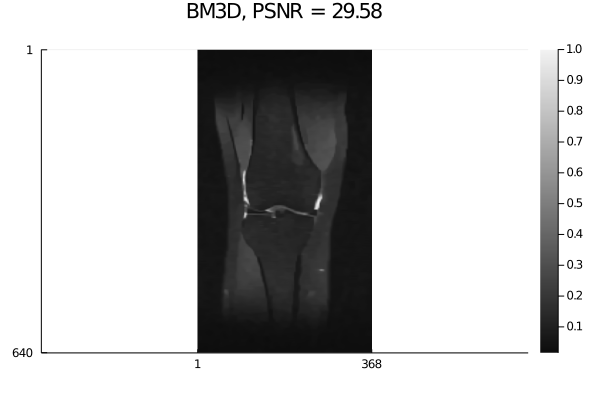

In [51]:
psnrBM3D = assess_psnr(x̂BM3D, img) # PSNR
pBM3D = jim(abs.(rev(x̂BM3D)), title="BM3D, PSNR = $(round(psnrBM3D, digits = 2))")

### Using normalization

In [60]:
# Setup the plug
plug = plugs["norm"]
# Reconstruct
x̂Norm, nrmse_pogm = pogm_restart(
    x0[:],
    (x) -> undef,
    (x) -> A'*(A*x-y),
    2,
    g_prox = (x, c) -> plug(reshape(x, M, N))[:],
    restart = :none, 
    niter = nIter,
    fun = (aa,x,ac,ad) -> rmse(x, img[:])
    )

# Reshape an normalize
x̂Norm = normIm( reshape(abs.(x̂Norm), M, N) );

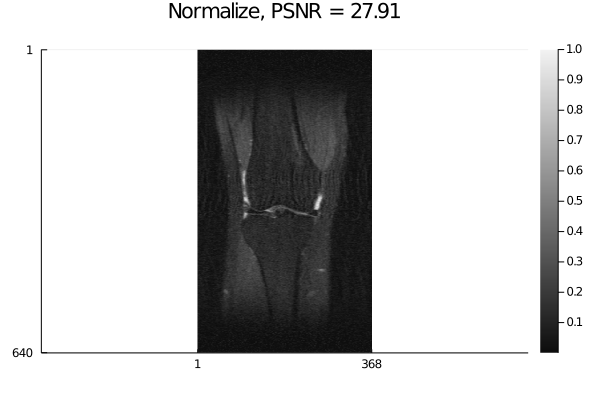

In [61]:
psnrNorm = assess_psnr(x̂Norm, img) # PSNR
pNorm = jim(abs.(rev(x̂Norm)), title="Normalize, PSNR = $(round(psnrNorm, digits = 2))")

In [70]:
@show psnrNLMeans
@show psnrTv
@show psnrDNCNN 
@show psnrBM3D
@show psnrNorm;

psnrNLMeans = 27.905972f0
psnrTv = 28.250628776717793
psnrDNCNN = 27.946205f0
psnrBM3D = 29.58047148523006
psnrNorm = 27.91244154283384


In [64]:
psnrNoisey = assess_psnr(noisy_img, img) # PSNR
pNoisey = jim(abs.(rev(noisy_img)),title="Noisy input, PSNR = $(round(psnrNoisey, digits = 2))");

plot(j1, pNoisey, j2, pDNCNN, pNLMeans, pBM3D, pTv, pNorm, layout = (2,4), colorbar = false, size = (900,700), titlefontsize = 10)

In [69]:
savefig("pogm_knee_R8_norm.pdf")